In [1]:
import cv2
import torch
import random
import csv
import time
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import os

In [39]:
class P_net_Dataset(Dataset):
    def __init__(self, path, transform=None):
        with open(path, 'r') as f:
            self.lines = f.readlines()
        self.transform = transform
        
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        line = self.lines[idx].strip().split()

        img_path, label, offset = line[0], line[1], line[2:6]
        
        img = Image.open(img_path).convert('RGB')
        label = int(label)
        offset = np.array([float(x) for x in offset])
        
        sample = {'image': img, 'label': label, 'offset': offset}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [3]:
class ToTensor:
    def __call__(self, sample):
        image, label, offset = sample.values()
        
        image = transforms.ToTensor()(image)
        label = torch.from_numpy(np.array(label)).float()
        offset = torch.from_numpy(offset).float()
        
        return {'image': image, 'label': label, 'offset': offset}

In [4]:
class Random_Filp:
    def __call__(self, sample):
        image, label, offset = sample.values()

        pred = random.uniform(0, 1)
        if pred > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            offset[0], offset[2] = -offset[2], -offset[0]
            
        return {'image': image, 'label': label, 'offset': offset}

In [5]:
path = './anno_store/imglist_anno_12.txt'
trfm = transforms.Compose([Random_Filp(), ToTensor()])

img_show = P_net_Dataset(path)

[20498, 10629, 13756, 8084, 16872]
[-1, 0, -1, 0, -1]
[array([-0.26, -0.11, -0.13, -0.13]), array([0., 0., 0., 0.]), array([-0.2 , -0.17, -0.14,  0.26]), array([0., 0., 0., 0.]), array([ 0.08, -0.1 ,  0.29,  0.65])]


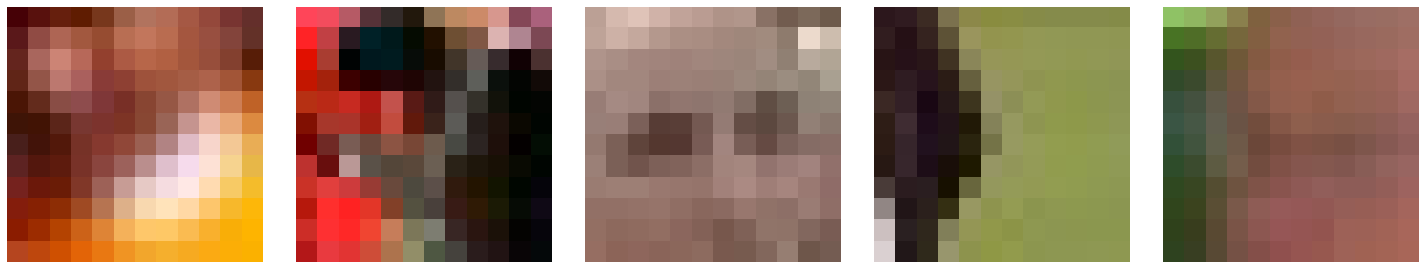

In [6]:
def my_show(data, nums):
    fig = plt.figure(figsize=(20, 5))
    lst = []
    labels = []
    offsets = []
    
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(0, len(data))
        img, label, offset = data[n].values()
        
        lst.append(n)
        labels.append(label)
        offsets.append(offset)
        
        ax.imshow(np.array(img))
        ax.axis('off')
    print(lst)
    print(labels)
    print(offsets)
    
my_show(img_show, 5)
        
        
        

In [7]:
class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),   # size 10 * 10 * 10
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),     # size 5 * 5 * 10
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  # size 3 * 3 * 16
            nn.PReLU(),  
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # size 1 * 1 * 32
            nn.PReLU()  
        )
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1) # size 1 * 1 * 1 
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1) # size 1 * 1 * 4

    def forward(self, x):
        x = self.pre_layer(x)
        
        # 之后label被用作score
        label = torch.sigmoid(self.conv4_1(x))
        offset = self.conv4_2(x)

        return label, offset


In [34]:
def train_pnet(model_path, epoch, data_path, trfm, batch_size ,lr):

    
    dataset = P_net_Dataset(data_path, trfm)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    pnet = PNet()
    criterion_cls = nn.BCELoss()
    criterion_box = nn.MSELoss()
    optimizer = optim.Adam(pnet.parameters(), lr=lr)
    
    since = time.time()
    best_model_wts = copy.deepcopy(pnet.state_dict())
    best_valid_loss = float('inf')
    
    t = 0
    
    for epoch_idx in range(epoch):
        pnet.train()
        epoch_time = time.time()
        loss_label_totle = 0.0
        loss_offset_totle = 0.0
        acc_positive = 0.0
        acc_negative = 0.0
        times = 0
        
        for batch_idx, batch in enumerate(train_dataloader):
            image, label, offset = batch.values()
            
            # batch的零头数据量过少，可能出现标签都没有的情况
            if label.size(0) < batch_size:
                continue
            
            # 进网络
            p_label, p_offset = pnet(image)
            
            # 卷积出来是三维的要压缩掉两维
            p_offset = torch.squeeze(p_offset)
            p_label = torch.squeeze(p_label)
            
            # label算loss只要用到1， 0标签的数据
            gt_label = label[label != -1]
            pre_label = p_label[label != -1]
            
            # 偏移算loss 用到-1， 1标签的数据（难正样本，正样本）
            gt_offset = offset[label != 0]
            pre_offset = p_offset[label != 0]

            loss_cls = criterion_cls(pre_label, gt_label)
            loss_box = criterion_box(pre_offset, gt_offset)
            
            # 分类loss加了个权重
            loss = loss_cls + 0.5 * loss_box
            
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # log
            pred = torch.ge(pre_label, 0.6).float()
            
            acc_positive += (gt_label[gt_label == 1] == pred[gt_label == 1]).sum().item() / (gt_label[gt_label == 1].size(0) + 0.001)
            acc_negative += (gt_label[gt_label == 0] == pred[gt_label == 0]).sum().item() / (gt_label[gt_label == 0].size(0) + 0.001)
            
            loss_label_totle += loss_cls.item()
            loss_offset_totle += (loss_box * 0.5).item()
            times += 1
        
        loss_label_totle /= times
        loss_offset_totle /= times
        loss_totle = loss_label_totle + loss_offset_totle
        acc_positive /= times
        acc_negative /= times
        t = time.time() - epoch_time
        
        if epoch_idx % 1 == 0:
            print('Epoch {} spend: {:.0f}m {:.0f}s'.format(epoch_idx, t // 60, t % 60))
            print('Valid: loss_totle: {:.4f} loss_label: {:.4f} loss_offset: {:.4f}'.format(loss_totle, loss_label_totle, loss_offset_totle))
            print('Label: acc_positive: {:.4f}, acc_negative: {:.4f}'.format(acc_positive, acc_negative))
            print('-' * 20)
            
        # 取loss最小的参数
        if loss_totle < best_valid_loss:
            best_model_wts = copy.deepcopy(pnet.state_dict())
            best_valid_loss = loss_totle
    
    pnet.load_state_dict(best_model_wts)
    time_elapesd = time.time() - since
    torch.save(pnet.state_dict(), model_path)
    
    print('=' * 50)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapesd // 60, time_elapesd % 60))
    print('Best val loss: {:4f}'.format(best_valid_loss))


In [35]:
model_path = './model_store/pnet.pkl'
data_path = './anno_store/imglist_anno_12.txt'
trfm = transforms.Compose([Random_Filp(), ToTensor()])
batch_size = 128
lr = 0.001
epoch = 20

In [36]:
train_pnet(model_path, epoch, data_path, trfm, batch_size ,lr)

Epoch 0 spend: 0m 16s
Valid: loss_totle: 0.4285 loss_label: 0.4144 loss_offset: 0.0141
Label: acc_positive: 0.0338, acc_negative: 0.9918
--------------------
Epoch 1 spend: 0m 6s
Valid: loss_totle: 0.3525 loss_label: 0.3411 loss_offset: 0.0114
Label: acc_positive: 0.3223, acc_negative: 0.9669
--------------------
Epoch 2 spend: 0m 6s
Valid: loss_totle: 0.3035 loss_label: 0.2926 loss_offset: 0.0109
Label: acc_positive: 0.5004, acc_negative: 0.9711
--------------------
Epoch 3 spend: 0m 6s
Valid: loss_totle: 0.2634 loss_label: 0.2528 loss_offset: 0.0106
Label: acc_positive: 0.6021, acc_negative: 0.9729
--------------------
Epoch 4 spend: 0m 6s
Valid: loss_totle: 0.2411 loss_label: 0.2308 loss_offset: 0.0103
Label: acc_positive: 0.6528, acc_negative: 0.9727
--------------------
Epoch 5 spend: 0m 6s
Valid: loss_totle: 0.2290 loss_label: 0.2189 loss_offset: 0.0101
Label: acc_positive: 0.6763, acc_negative: 0.9741
--------------------
Epoch 6 spend: 0m 6s
Valid: loss_totle: 0.2204 loss_label